GraphSAGE算法
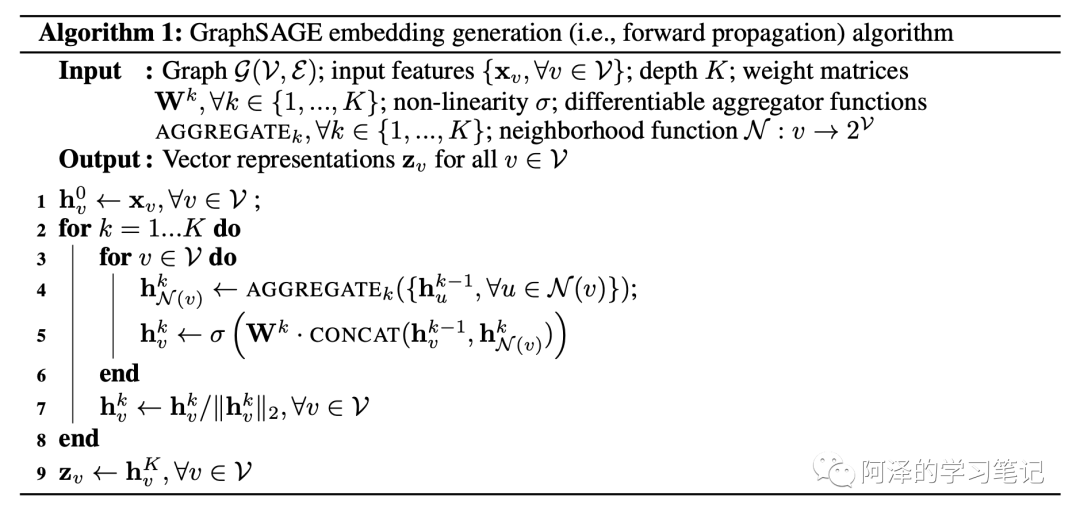

dgl 已经实现了 SAGEConv 层，可以直接导入。  
有了 SAGEConv 层后，GraphSAGE 实现起来就比较简单。  
和基于 GraphConv 实现 GCN 的唯一区别在于把 GraphConv 改成了 SAGEConv：  

In [1]:
import torch
from torch import nn
from torch.nn import functional as F

import dgl
from dgl.nn import SAGEConv
class GraphSAGE(nn.Module):
    def __init__(self,
                 g,
                 in_feats,
                 n_hidden,
                 n_classes,
                 n_layers,
                 activation,
                 dropout,
                 aggregator_type):
        super(GraphSAGE, self).__init__()
        self.layers = nn.ModuleList()
        self.g = g
        # input layer
        self.layers.append(SAGEConv(in_feats, n_hidden, aggregator_type,
                                    feat_drop=dropout, activation=activation))
        # hidden layers
        for i in range(n_layers - 1):
            self.layers.append(SAGEConv(n_hidden, n_hidden, aggregator_type,
                                        feat_drop=dropout, activation=activation))
        # output layer
        self.layers.append(SAGEConv(n_hidden, n_classes, aggregator_type,
                                    feat_drop=dropout, activation=None)) # activation None
        
    def forward(self, features):
        h = features
        for layer in self.layers:
            h = layer(self.g, h)
        return h

Using backend: pytorch
D:\Program Files\anaconda3\lib\site-packages\dgl\base.py:45: DGLWarning: Detected an old version of PyTorch. Suggest using torch>=1.5.0 for the best experience.
  return warnings.warn(message, category=category, stacklevel=1)


首先我们来看下dgl中封装的SAGEConv  
'https://docs.dgl.ai/_modules/dgl/nn/pytorch/conv/sageconv.html#SAGEConv'

Bases: torch.nn.modules.module.Module  
首先是SAGEConv的父类：nn.Module，也就是SAGEConv是继承于nn.Module，很明显nn.Module是一个公共模块，定义了一个neural network modules常用的属性

我们来看下nn.Module中有哪些内容
??nn.Module

class Module(object):
    r"""Base class for all neural network modules.

    Your models should also subclass this class.

    Modules can also contain other Modules, allowing to nest them in
    a tree structure. You can assign the submodules as regular attributes::

        import torch.nn as nn
        import torch.nn.functional as F

        class Model(nn.Module):
            def __init__(self):
                super(Model, self).__init__()
                self.conv1 = nn.Conv2d(1, 20, 5)
                self.conv2 = nn.Conv2d(20, 20, 5)

            def forward(self, x):
                x = F.relu(self.conv1(x))
                return F.relu(self.conv2(x))

    Submodules assigned in this way will be registered, and will have their
    parameters converted too when you call :meth:`to`, etc.
    """
我们可以看到Module的一个示例，自定义class Model继承于(nn.Module)，Model中叠加了两层卷积conv2d，并通过forward实现前向传播

GraphSAGE layer from paper Inductive Representation Learning on Large Graphs. 
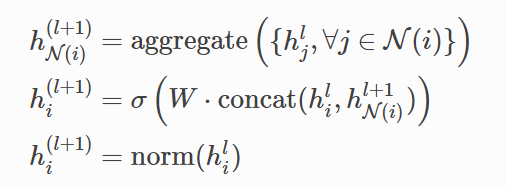
GraphSAGE公式，看过论文的同学肯定知道含义了

原文中aggregate有多种形式，后续会介绍，下面先照搬doc中的内容，熟悉下GraphSAGE的参数，过程中试着将参数与上述公式对应起来，加深理解

Parameters
in_feats (int, or pair of ints) –

Input feature size; i.e, the number of dimensions of h(l)i.

**SAGEConv can be applied on homogeneous graph and unidirectional bipartite graph**. If the layer applies on a unidirectional bipartite graph, in_feats specifies the input feature size on both the source and destination nodes. If a scalar is given, the source and destination node feature size would take the same value.

If aggregator type is gcn, the feature size of source and destination nodes are required to be the same.
why?? Because you need to concat hv and hu

out_feats (int) – Output feature size; i.e, the number of dimensions of h(l+1)i.

feat_drop (float) – Dropout rate on features, default: 0.

aggregator_type (str) – Aggregator type to use **(mean, gcn, pool, lstm)**.

bias (bool) – If True, adds a learnable bias to the output. Default: True.

norm (callable activation function/layer or None, optional) – If not None, applies normalization to the updated node features.

activation (callable activation function/layer or None, optional) – If not None, applies an activation function to the updated node features. Default: None.

用中文再来一遍
SAGEConv 接收七个参数：
in_feat：输入的特征大小，可以是一个整型数，也可以是两个整型数。如果用在单向二部图上，则可以用整型数来分别表示源节点和目的节点的特征大小，如果只给一个的话，则默认源节点和目的节点的特征大小一致。需要注意的是，如果参数 aggregator_type 为 gcn 的话，则源节点和目的节点的特征大小必须一致；
out_feats：输出特征大小；
aggregator_type：聚合类型，目前支持 mean、gcn、pool、lstm，比论文多一个 gcn 聚合，gcn 聚合可以理解为周围所有的邻居结合和当前节点的均值；
feat_drop=0.：特征 drop 的概率，默认为 0；
bias=True：输出层的 bias，默认为 True；
norm=None：归一化，可以选择一个归一化的方式，默认为 None
activation=None：激活函数，可以选择一个激活函数去更新节点特征，默认为 None。

In [5]:
"""Torch Module for GraphSAGE layer"""
# pylint: disable= no-member, arguments-differ, invalid-name
import torch
from torch import nn
from torch.nn import functional as F

from .... import function as fn
from ....utils import expand_as_pair, check_eq_shape


class SAGEConv(nn.Module):
    r"""
    Examples
    --------
    >>> import dgl
    >>> import numpy as np
    >>> import torch as th
    >>> from dgl.nn import SAGEConv

    >>> # Case 1: Homogeneous graph
    >>> g = dgl.graph(([0,1,2,3,2,5], [1,2,3,4,0,3]))
    >>> g = dgl.add_self_loop(g)
    >>> feat = th.ones(6, 10)
    >>> conv = SAGEConv(10, 2, 'pool')
    >>> res = conv(g, feat)
    >>> res
    tensor([[-1.0888, -2.1099],
            [-1.0888, -2.1099],
            [-1.0888, -2.1099],
            [-1.0888, -2.1099],
            [-1.0888, -2.1099],
            [-1.0888, -2.1099]], grad_fn=<AddBackward0>)

    >>> # Case 2: Unidirectional bipartite graph
    >>> u = [0, 1, 0, 0, 1]
    >>> v = [0, 1, 2, 3, 2]
    >>> g = dgl.bipartite((u, v))
    >>> u_fea = th.rand(2, 5)
    >>> v_fea = th.rand(4, 10)
    >>> conv = SAGEConv((5, 10), 2, 'mean')
    >>> res = conv(g, (u_fea, v_fea))
    >>> res
    tensor([[ 0.3163,  3.1166],
            [ 0.3866,  2.5398],
            [ 0.5873,  1.6597],
            [-0.2502,  2.8068]], grad_fn=<AddBackward0>)
    """
    def __init__(self,
                 in_feats,
                 out_feats,
                 aggregator_type,
                 feat_drop=0.,
                 bias=True,
                 norm=None,
                 activation=None):
        super(SAGEConv, self).__init__()

        #??dgl.utils.expand_as_pair:Return a pair of same element if the input is not a pair.
        #expand_as_pair:函数可以返回一个二维元组,元素与input相同
        self._in_src_feats, self._in_dst_feats = expand_as_pair(in_feats)
        self._out_feats = out_feats
        self._aggre_type = aggregator_type
        self.norm = norm
        self.feat_drop = nn.Dropout(feat_drop)
        self.activation = activation
        # aggregator type: mean/pool/lstm/gcn
        if aggregator_type == 'pool':
            self.fc_pool = nn.Linear(self._in_src_feats, self._in_src_feats) #邻居节点进行一次W，即先进行一次线性变换
        if aggregator_type == 'lstm':
            self.lstm = nn.LSTM(self._in_src_feats, self._in_src_feats, batch_first=True) 
        if aggregator_type != 'gcn':
            self.fc_self = nn.Linear(self._in_dst_feats, out_feats, bias=bias) #如果不是GCN，自身节点进行一次线性变换
        self.fc_neigh = nn.Linear(self._in_src_feats, out_feats, bias=bias) #邻居节点进行一次输入-输出的线性变换
        self.reset_parameters()

    def reset_parameters(self):
        r"""

        Description
        -----------
        Reinitialize learnable parameters.

        Note
        ----
        The linear weights :math:`W^{(l)}` are initialized using Glorot uniform initialization.
        The LSTM module is using xavier initialization method for its weights.
        """
        """初始化参数
        这里的 gain 可以从 calculate_gain 中获取针对非线形激活函数的建议的值
        用于初始化参数
        """
        gain = nn.init.calculate_gain('relu')
        if self._aggre_type == 'pool':
            nn.init.xavier_uniform_(self.fc_pool.weight, gain=gain)
        if self._aggre_type == 'lstm':
            self.lstm.reset_parameters()
        if self._aggre_type != 'gcn':
            nn.init.xavier_uniform_(self.fc_self.weight, gain=gain)
        nn.init.xavier_uniform_(self.fc_neigh.weight, gain=gain)

    def _lstm_reducer(self, nodes):
        """LSTM reducer
        NOTE(zihao): lstm reducer with default schedule (degree bucketing)
        is slow, we could accelerate this with degree padding in the future.
        """
        m = nodes.mailbox['m'] # (B, L, D)
        batch_size = m.shape[0]
        h = (m.new_zeros((1, batch_size, self._in_src_feats)),
             m.new_zeros((1, batch_size, self._in_src_feats)))
        _, (rst, _) = self.lstm(m, h)
        return {'neigh': rst.squeeze(0)}

    def forward(self, graph, feat):
        r"""

        Description
        -----------
        Compute GraphSAGE layer.

        Parameters
        ----------
        graph : DGLGraph
            The graph.
        feat : torch.Tensor or pair of torch.Tensor
            If a torch.Tensor is given, it represents the input feature of shape
            :math:`(N, D_{in})`
            where :math:`D_{in}` is size of input feature, :math:`N` is the number of nodes.
            If a pair of torch.Tensor is given, the pair must contain two tensors of shape
            :math:`(N_{in}, D_{in_{src}})` and :math:`(N_{out}, D_{in_{dst}})`.

        Returns
        -------
        torch.Tensor
            The output feature of shape :math:`(N, D_{out})` where :math:`D_{out}`
            is size of output feature.
        """
        with graph.local_scope():
            if isinstance(feat, tuple):
                feat_src = self.feat_drop(feat[0])
                feat_dst = self.feat_drop(feat[1])
            else:
                feat_src = feat_dst = self.feat_drop(feat)
                if graph.is_block:
                    feat_dst = feat_src[:graph.number_of_dst_nodes()]

            h_self = feat_dst

            # Handle the case of graphs without edges
            if graph.number_of_edges() == 0:
                graph.dstdata['neigh'] = torch.zeros(
                    feat_dst.shape[0], self._in_src_feats).to(feat_dst)

            if self._aggre_type == 'mean':
                graph.srcdata['h'] = feat_src
                graph.update_all(fn.copy_src('h', 'm'), fn.mean('m', 'neigh'))
                h_neigh = graph.dstdata['neigh']
            elif self._aggre_type == 'gcn':
                check_eq_shape(feat)
                graph.srcdata['h'] = feat_src
                graph.dstdata['h'] = feat_dst     # same as above if homogeneous
                graph.update_all(fn.copy_src('h', 'm'), fn.sum('m', 'neigh'))
                # divide in_degrees
                degs = graph.in_degrees().to(feat_dst)
                h_neigh = (graph.dstdata['neigh'] + graph.dstdata['h']) / (degs.unsqueeze(-1) + 1)
            elif self._aggre_type == 'pool':
                graph.srcdata['h'] = F.relu(self.fc_pool(feat_src))
                graph.update_all(fn.copy_src('h', 'm'), fn.max('m', 'neigh'))
                h_neigh = graph.dstdata['neigh']
            elif self._aggre_type == 'lstm':
                graph.srcdata['h'] = feat_src
                graph.update_all(fn.copy_src('h', 'm'), self._lstm_reducer)
                h_neigh = graph.dstdata['neigh']
            else:
                raise KeyError('Aggregator type {} not recognized.'.format(self._aggre_type))

            # GraphSAGE GCN does not require fc_self.
            if self._aggre_type == 'gcn':
                rst = self.fc_neigh(h_neigh)
            else:
                rst = self.fc_self(h_self) + self.fc_neigh(h_neigh)
            # activation
            if self.activation is not None:
                rst = self.activation(rst)
            # normalization
            if self.norm is not None:
                rst = self.norm(rst)
            return rst


In [10]:
#理解expand_as_pair
dgl.utils.expand_as_pair(2),dgl.utils.expand_as_pair(torch.tensor([1,2,3]))

((2, 2), (tensor([1, 2, 3]), tensor([1, 2, 3])))

??nn.LSTM


Glorot uniform initialization

xavier initialization method